# Smoothed Disperser transmission study for HD111980


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [1]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [4]:
from scipy import interpolate

In [5]:
import seaborn as sns

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Figure style

In [7]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [8]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [9]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../merra2'

In [10]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [11]:
from spectractor import *
from spectractorsim import *
from libspecana import *

REL_PATH= ../../../SpectractorAnaAtm/common_tools
ABS_PATH= /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm/common_tools/libspecana.pyc
PYFILE_NAME= libspecana.pyc
PATH_SPECTRACTORSIM= ../../../SpectractorAnaAtm/common_tools/../../SpectractorSim


## Input spectra

### LogBook

In [12]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [13]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [14]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [15]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [16]:
home=os.getenv('HOME')

In [17]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [18]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [19]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [20]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [21]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [22]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [23]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [24]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

In [25]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [26]:
date="20170530"

In [27]:
idx_sel_subdir=2

In [28]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [29]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [30]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [31]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [32]:
wlshift.head()

,index,wlshift
0,57,-6.633933
1,58,-3.083037
2,60,-8.383797
3,61,-2.846134
4,62,-5.646836


### path for spectra

In [33]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [34]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [35]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [36]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [37]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits
2017-05-31T00:02:18.596,58,783,"9,3",26,"1,051","0,94",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_058.fits
2017-05-31T00:06:14.000,60,783,"9,1",26,"1,047","1,018",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_060.fits
2017-05-31T00:08:06.454,61,783,"9,2",26,"1,045","0,939",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_061.fits
2017-05-31T00:09:58.852,62,783,"9,1",26,"1,044","0,846",60,HD111980,dia,HoloPhP,12450,"5,8",data_30may17,reduc_20170530_062.fits


In [38]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T10:33:46.896,280,782,11,20,"1,018","0,793",60,HD205905,dia,Ron400,12400,"14,5",data_30may17,reduc_20170530_280.fits
2017-05-31T10:35:39.245,281,782,"11,2",20,"1,019","0,793",60,HD205905,dia,Thor300,12400,"13,1",data_30may17,reduc_20170530_281.fits
2017-05-31T10:37:31.598,282,782,11,20,"1,021","0,793",60,HD205905,dia,HoloPhP,12400,"12,5",data_30may17,reduc_20170530_282.fits
2017-05-31T10:39:24.046,283,782,11,20,"1,022","0,793",120,HD205905,dia,HoloPhAg,12400,"12,8",data_30may17,reduc_20170530_283.fits
2017-05-31T10:42:16.450,284,782,11,20,"1,024","0,793",120,HD205905,dia,HoloAmAg,12400,"13,2",data_30may17,reduc_20170530_284.fits


### Quick view on the kind of sources

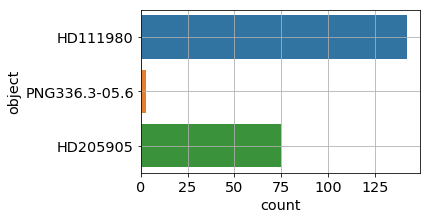

In [39]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

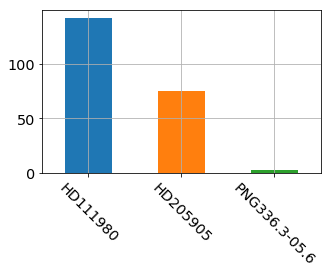

In [40]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [41]:
bad_obs_0=sel_obs.loc[sel_obs['index'].isin([57])]

In [42]:
bad_obs_0

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits


### Remove bad sources

- remove star **PNG336.3-05.6**

In [43]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD205905'])]
bad_indexes=bad_obs["index"]

In [44]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T05:56:35.901,200,783,"9,3",23,"1,089","0,829",300,PNG336.3-05.6,dia,Thor300,12450,7,data_30may17,reduc_20170530_200.fits
2017-05-31T06:05:21.701,201,783,"9,4",23,"1,095","0,737",600,PNG336.3-05.6,dia,HoloPhP,12450,"8,5",data_30may17,reduc_20170530_201.fits
2017-05-31T07:03:12.652,205,783,"9,5",24,"1,158","0,941",600,PNG336.3-05.6,dia,HoloPhP,12400,"10,8",data_30may17,reduc_20170530_205.fits
2017-05-31T07:54:38.806,210,782,"9,5",23,"1,101","0,793",60,HD205905,dia,Ron400,12400,"11,6",data_30may17,reduc_20170530_210.fits
2017-05-31T07:56:31.293,211,782,"9,4",24,"1,097","0,793",60,HD205905,dia,Thor300,12400,"11,5",data_30may17,reduc_20170530_211.fits
2017-05-31T07:58:23.653,212,782,"9,5",24,"1,094","0,793",60,HD205905,dia,HoloPhP,12400,"10,5",data_30may17,reduc_20170530_212.fits
2017-05-31T08:00:16.053,213,782,"9,7",23,"1,09","0,793",120,HD205905,dia,HoloPhAg,12400,12,data_30may17,reduc_20170530_213.fits
2017-05-31T08:03:08.495,214,782,"9,6",23,"1,085","0,793",120,HD205905,dia,HoloAmAg,12400,"13,4",data_30may17,reduc_20170530_214.fits
2017-05-31T08:06:00.847,215,782,"9,6",23,"1,08","0,793",60,HD205905,dia,Ron400,12400,"15,4",data_30may17,reduc_20170530_215.fits


In [45]:
bad_indexes=bad_obs.loc[:,"index"]

In [46]:
bad_indexes.index

Index([u'2017-05-31T05:56:35.901', u'2017-05-31T06:05:21.701',
       u'2017-05-31T07:03:12.652', u'2017-05-31T07:54:38.806',
       u'2017-05-31T07:56:31.293', u'2017-05-31T07:58:23.653',
       u'2017-05-31T08:00:16.053', u'2017-05-31T08:03:08.495',
       u'2017-05-31T08:06:00.847', u'2017-05-31T08:07:53.254',
       u'2017-05-31T08:09:45.655', u'2017-05-31T08:11:37.854',
       u'2017-05-31T08:14:30.301', u'2017-05-31T08:17:22.698',
       u'2017-05-31T08:19:15.101', u'2017-05-31T08:21:07.405',
       u'2017-05-31T08:22:59.809', u'2017-05-31T08:25:52.205',
       u'2017-05-31T08:28:44.549', u'2017-05-31T08:30:37.007',
       u'2017-05-31T08:32:29.446', u'2017-05-31T08:34:21.908',
       u'2017-05-31T08:37:14.395', u'2017-05-31T08:40:06.801',
       u'2017-05-31T08:41:59.205', u'2017-05-31T08:43:51.549',
       u'2017-05-31T08:45:44.007', u'2017-05-31T08:48:36.303',
       u'2017-05-31T08:51:28.895', u'2017-05-31T08:53:21.253',
       u'2017-05-31T08:55:13.701', u'2017-05-31T08:57:0

In [47]:
bad_indexes.values

array([200, 201, 205, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284])

### Concatenate bad obs

In [48]:
bad_obs=pd.concat([bad_obs,bad_obs_0])

In [49]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T05:56:35.901,200,783,"9,3",23,"1,089","0,829",300,PNG336.3-05.6,dia,Thor300,12450,7,data_30may17,reduc_20170530_200.fits
2017-05-31T06:05:21.701,201,783,"9,4",23,"1,095","0,737",600,PNG336.3-05.6,dia,HoloPhP,12450,"8,5",data_30may17,reduc_20170530_201.fits
2017-05-31T07:03:12.652,205,783,"9,5",24,"1,158","0,941",600,PNG336.3-05.6,dia,HoloPhP,12400,"10,8",data_30may17,reduc_20170530_205.fits
2017-05-31T07:54:38.806,210,782,"9,5",23,"1,101","0,793",60,HD205905,dia,Ron400,12400,"11,6",data_30may17,reduc_20170530_210.fits
2017-05-31T07:56:31.293,211,782,"9,4",24,"1,097","0,793",60,HD205905,dia,Thor300,12400,"11,5",data_30may17,reduc_20170530_211.fits
2017-05-31T07:58:23.653,212,782,"9,5",24,"1,094","0,793",60,HD205905,dia,HoloPhP,12400,"10,5",data_30may17,reduc_20170530_212.fits
2017-05-31T08:00:16.053,213,782,"9,7",23,"1,09","0,793",120,HD205905,dia,HoloPhAg,12400,12,data_30may17,reduc_20170530_213.fits
2017-05-31T08:03:08.495,214,782,"9,6",23,"1,085","0,793",120,HD205905,dia,HoloAmAg,12400,"13,4",data_30may17,reduc_20170530_214.fits
2017-05-31T08:06:00.847,215,782,"9,6",23,"1,08","0,793",60,HD205905,dia,Ron400,12400,"15,4",data_30may17,reduc_20170530_215.fits


In [50]:
bad_obs.sort_values(by="index",inplace=True)

In [51]:
bad_indexes=bad_obs.loc[:,"index"]

In [52]:
bad_indexes.index

Index([u'2017-05-31T00:00:26.147', u'2017-05-31T05:56:35.901',
       u'2017-05-31T06:05:21.701', u'2017-05-31T07:03:12.652',
       u'2017-05-31T07:54:38.806', u'2017-05-31T07:56:31.293',
       u'2017-05-31T07:58:23.653', u'2017-05-31T08:00:16.053',
       u'2017-05-31T08:03:08.495', u'2017-05-31T08:06:00.847',
       u'2017-05-31T08:07:53.254', u'2017-05-31T08:09:45.655',
       u'2017-05-31T08:11:37.854', u'2017-05-31T08:14:30.301',
       u'2017-05-31T08:17:22.698', u'2017-05-31T08:19:15.101',
       u'2017-05-31T08:21:07.405', u'2017-05-31T08:22:59.809',
       u'2017-05-31T08:25:52.205', u'2017-05-31T08:28:44.549',
       u'2017-05-31T08:30:37.007', u'2017-05-31T08:32:29.446',
       u'2017-05-31T08:34:21.908', u'2017-05-31T08:37:14.395',
       u'2017-05-31T08:40:06.801', u'2017-05-31T08:41:59.205',
       u'2017-05-31T08:43:51.549', u'2017-05-31T08:45:44.007',
       u'2017-05-31T08:48:36.303', u'2017-05-31T08:51:28.895',
       u'2017-05-31T08:53:21.253', u'2017-05-31T08:55:1

In [53]:
bad_indexes.values

array([ 57, 200, 201, 205, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284])

- keep stars **HD111980**, **HD205905**

In [54]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD111980','HD205905'])]

In [55]:
sel2_obs=sel2_obs[sel2_obs.index !=57]      # REMOVE 57

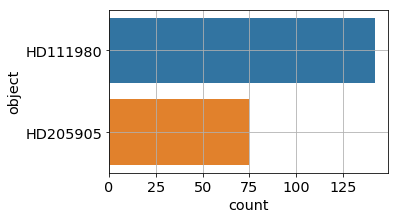

In [56]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [57]:
list_of_objects=sel2_obs['object'].values

In [58]:
list_of_objects=set(list_of_objects)

In [59]:
list_of_objects=list(list_of_objects)

In [60]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [61]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [62]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [63]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_060_spectrum.fits']

In [64]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [65]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_060_spectrum.fits']

In [66]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [67]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_060_spectrum.fits']

# Remove bad indexes

In [68]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170530_057_spectrum.fits
 remove  reduc_20170530_200_spectrum.fits
 remove  reduc_20170530_201_spectrum.fits
 remove  reduc_20170530_205_spectrum.fits
 remove  reduc_20170530_210_spectrum.fits
 remove  reduc_20170530_211_spectrum.fits
 remove  reduc_20170530_212_spectrum.fits
 remove  reduc_20170530_213_spectrum.fits
 remove  reduc_20170530_214_spectrum.fits
 remove  reduc_20170530_215_spectrum.fits
 remove  reduc_20170530_216_spectrum.fits
 remove  reduc_20170530_217_spectrum.fits
 remove  reduc_20170530_218_spectrum.fits
 remove  reduc_20170530_219_spectrum.fits
 remove  reduc_20170530_220_spectrum.fits
 remove  reduc_20170530_221_spectrum.fits
 remove  reduc_20170530_222_spectrum.fits
 remove  reduc_20170530_223_spectrum.fits
 remove  reduc_20170530_224_spectrum.fits
 remove  reduc_20170530_225_spectrum.fits
 remove  reduc_20170530_226_spectrum.fits
 remove  reduc_20170530_227_spectrum.fits
 remove  reduc_20170530_228_spectrum.fits
 remove  reduc_20170530_229_spectr

In [69]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

In [70]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

In [71]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

# which filters

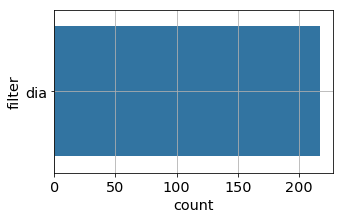

In [72]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

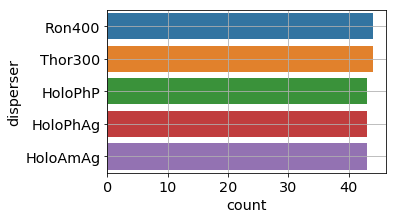

In [73]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [74]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [75]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [76]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [77]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [78]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

In [79]:
def PlotSpectra(the_filelist,the_obs,the_searchtag,the_title,Flag_corr_wl=False):
    
    jet =plt.get_cmap('jet') 
    VMAX=len(the_filelist)
    cNorm  = colors.Normalize(vmin=0, vmax=VMAX)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    
    
    the_selected_indexes=the_obs["index"].values  # get the array of index for that disperser
    
    plt.figure(figsize=(10,8))
    num=0
    for the_file in the_filelist:
        num+=1
        idx=get_index_from_filename(the_file,the_searchtag)
        if idx in the_selected_indexes:
            if FLAG_WL_CORRECTION and Flag_corr_wl:
                time_correction=wlshift[wlshift["index"]==idx].loc[:,"wlshift"].values[0]
            else:
                time_correction=0
            
            hdu = fits.open(the_file)
            data=hdu[0].data
            wl=data[0]+time_correction
            fl=data[1]
            colorVal = scalarMap.to_rgba(num,alpha=1)
            plt.plot(wl,fl,color=colorVal)
    plt.grid()    
    plt.title(the_title)
    plt.xlabel("$\lambda$ (nm)")   

## Show the reconstructed spectra

In [80]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170530_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [81]:
thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [82]:
#PlotSpectra(all_spectrafiles,sel_obs_Ron400,SearchTagRe,thetitle,Flag_corr_wl=True)

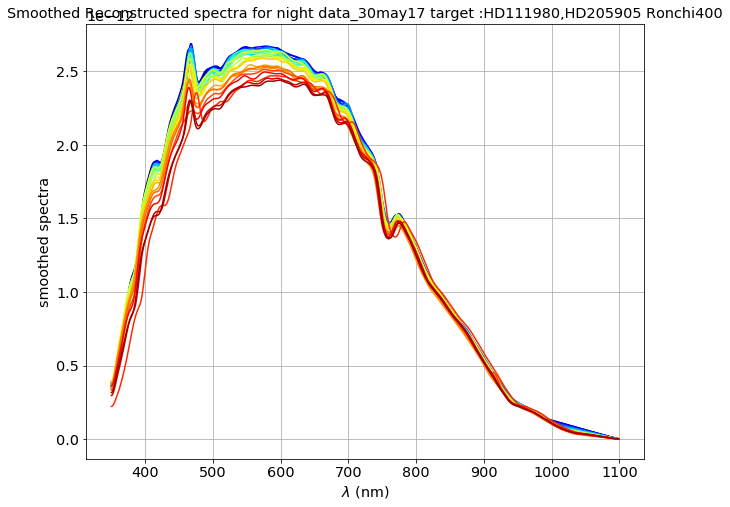

In [83]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### Thor 300

In [84]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

In [85]:
#PlotSpectra(all_spectrafiles,sel_obs_Thor300,SearchTagRe,thetitle,Flag_corr_wl=True)

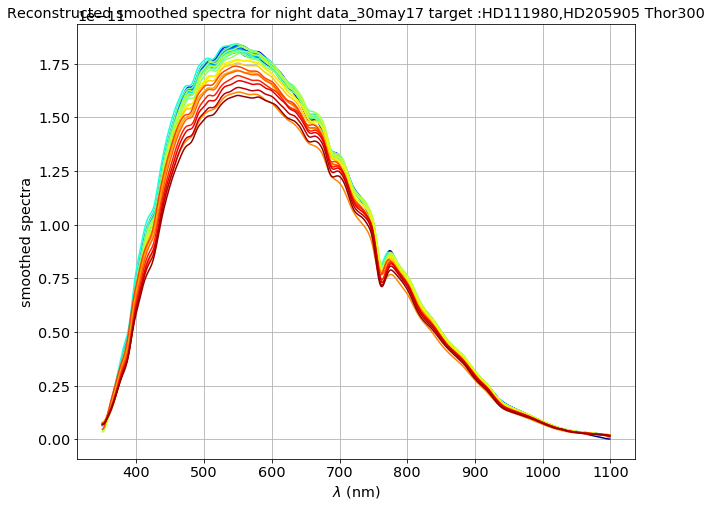

In [86]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhP

In [87]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

In [88]:
#PlotSpectra(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,thetitle,Flag_corr_wl=True)

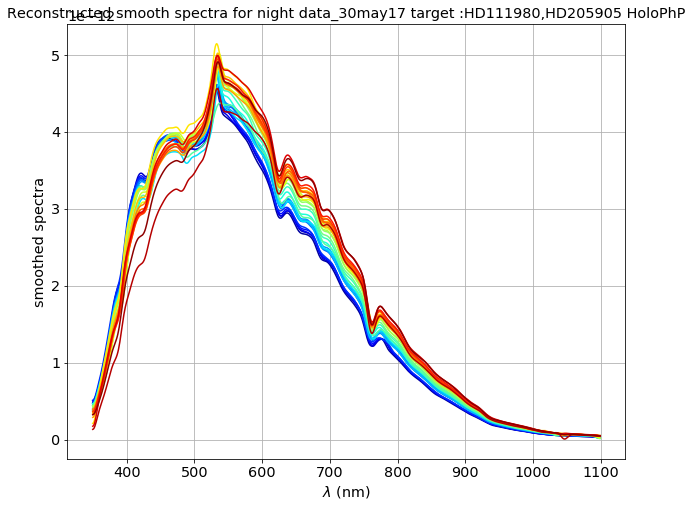

In [89]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhAg

In [90]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

In [91]:
#PlotSpectra(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,thetitle,Flag_corr_wl=True)

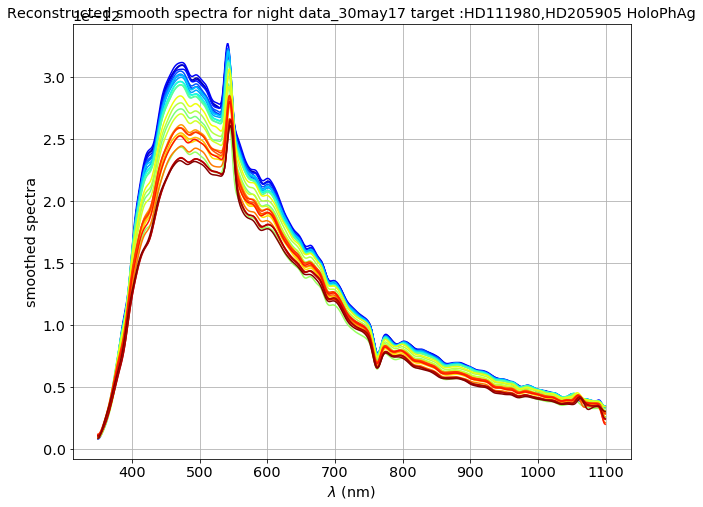

In [92]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloAmAg

In [93]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

In [94]:
#PlotSpectra(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,thetitle,Flag_corr_wl=True)

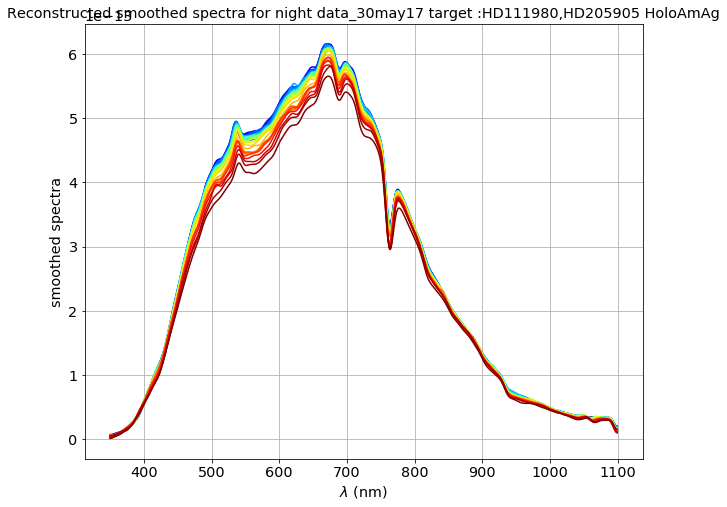

In [95]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Show the simulated spectra

In [96]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [97]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

In [98]:
#PlotSpectra(all_simspectrafiles1,sel2_obs,SearchTagRe,thetitle)

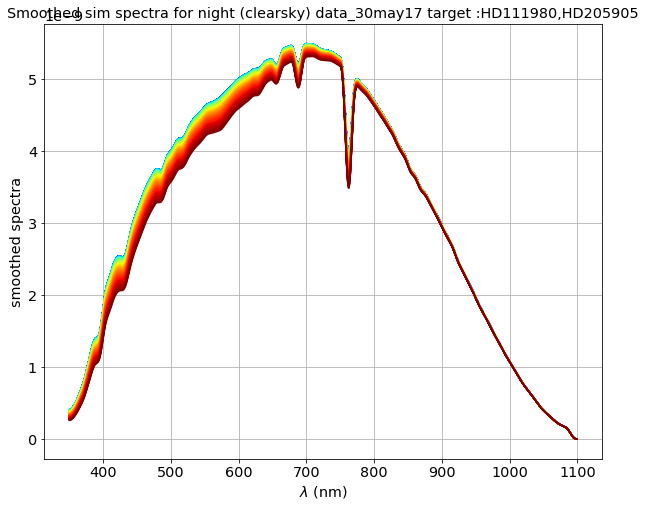

In [99]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### standard sky

In [100]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

In [101]:
#PlotSpectra(all_simspectrafiles2,sel2_obs,SearchTagRe,thetitle)

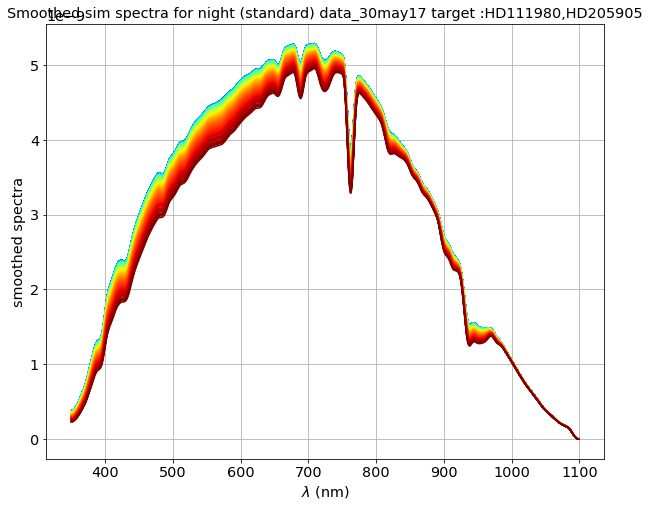

In [102]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### merra2 sky

In [103]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

In [104]:
#PlotSpectra(all_simspectrafiles3,sel2_obs,SearchTagRe,thetitle)

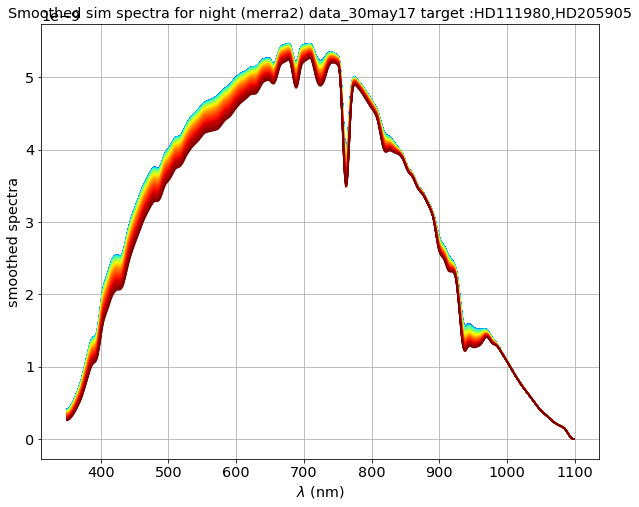

In [105]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

# Spectra ratio data/sim

In [106]:
def PlotSpectraRatio(the_filelist,path_tosims,the_obs,the_searchtag,the_title,Flag_corr_wl=False,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0):
    
    jet =plt.get_cmap('jet') 
    VMAX=len(the_filelist)
    cNorm  = colors.Normalize(vmin=0, vmax=VMAX)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    
    the_selected_indexes=the_obs["index"].values  # get the array of index for that disperser
    
    plt.figure(figsize=(10,8))
    num=0
    for the_file in the_filelist:  # loop on reconstruted spectra
        num+=1
        idx=get_index_from_filename(the_file,the_searchtag)
        if idx in the_selected_indexes:   
            
            if FLAG_WL_CORRECTION and Flag_corr_wl:
                wl_correction=wlshift[wlshift["index"]==idx].loc[:,"wlshift"].values[0]
            else:
                wl_correction=0
            
            
            # check if tthe index is in the disperser indexes 
            basefn=os.path.basename(the_file)                  # basename of reconstruced spectra
            basefn2=basefn.replace('reduc','specsim')  # reconstruct the simulation filename
            the_filesim=os.path.join(path_tosims,basefn2)  # add the path for the simulated file
            
            hdu1 = fits.open(the_file)
            data1=hdu1[0].data
            wl1=data1[0]+wl_correction
            fl1=data1[1]
            err1=data1[2]
            
            # extend range for (wl1,fl1)
            wl1=np.insert(wl1,0,WL[0])
            fl1=np.insert(fl1,0,0.)
            err1=np.insert(err1,0,0.)
            
            wl1=np.append(wl1,WL[-1])
            fl1=np.append(fl1,0.)
            err1=np.append(err1,0.)
            
            hdu2 = fits.open(the_filesim)
            data2=hdu2[0].data
            wl2=data2[0]
            fl2=data2[1]
            
            func = interpolate.interp1d(wl1, fl1)
            efunc = interpolate.interp1d(wl1, err1) 
            
            fl0=func(WL)
            er0=efunc(WL)
            
            f1_smooth=smooth(fl0,window_len=21)
            f2_smooth=smooth(fl2,window_len=21)
            
            ef1_smooth=smooth(er0,window_len=21)
            
            the_Y=f1_smooth/f2_smooth
            the_Y_err=ef1_smooth/f2_smooth
            
            sel_iii=np.where(np.logical_and(WL>=XMIN,WL<=XMAX))[0]
            the_Y_max=the_Y[sel_iii].max()*1.5
            
            colorVal = scalarMap.to_rgba(num,alpha=1)
            
            plt.plot(WL,the_Y,color=colorVal)
            plt.errorbar(WL,the_Y,yerr=the_Y_err,fmt = 'o',markersize = 1,color=colorVal,zorder = 300,antialiased = True)
            
            
    plt.xlim(XMIN,XMAX)
    
    if YMIN==0 and YMAX==0 :
        plt.ylim(0.,the_Y_max)
    else:
        plt.ylim(YMIN,YMAX)
        
    plt.grid()    
    plt.title(the_title)
    plt.xlabel("$\lambda$ (nm)")   
    plt.ylabel("spectra ratio")  

In [107]:
def PlotSpectraLogRatio(the_filelist,path_tosims,the_obs,the_searchtag,the_title,
                        Flag_corr_wl=False,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0):
    
    jet =plt.get_cmap('jet') 
    VMAX=len(the_filelist)
    cNorm  = colors.Normalize(vmin=0, vmax=VMAX)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    
    the_selected_indexes=the_obs["index"].values  # get the array of index for that disperser
    
    plt.figure(figsize=(10,8))
    num=0
    for the_file in the_filelist:  # loop on reconstruted spectra
        num+=1
        idx=get_index_from_filename(the_file,the_searchtag)
        
        if FLAG_WL_CORRECTION and Flag_corr_wl:
                wl_correction=wlshift[wlshift["index"]==idx].loc[:,"wlshift"].values[0]
        else:
                wl_correction=0
        
        
        if idx in the_selected_indexes:                # check if tthe index is in the disperser indexes 
            basefn=os.path.basename(the_file)                  # basename of reconstruced spectra
            basefn2=basefn.replace('reduc','specsim')  # reconstruct the simulation filename
            the_filesim=os.path.join(path_tosims,basefn2)  # add the path for the simulated file
            
            hdu1 = fits.open(the_file)
            data1=hdu1[0].data
            wl1=data1[0]+wl_correction
            fl1=data1[1]
            err1=data1[2]
            
            # extend range for (wl1,fl1)
            wl1=np.insert(wl1,0,WL[0])
            fl1=np.insert(fl1,0,0.)
            err1=np.insert(err1,0,0.)
            
            wl1=np.append(wl1,WL[-1])
            fl1=np.append(fl1,0.)
            err1=np.append(err1,0.)
            
            hdu2 = fits.open(the_filesim)
            data2=hdu2[0].data
            wl2=data2[0]
            fl2=data2[1]
            
            func = interpolate.interp1d(wl1, fl1)
            efunc = interpolate.interp1d(wl1, err1) 
            
            fl0=func(WL)
            er0=efunc(WL)
            
            f1_smooth=smooth(fl0,window_len=21)
            f2_smooth=smooth(fl2,window_len=21)
            
            #plt.plot(WL,2.5*(np.log10(fl0)-np.log10(fl2)))
            
            the_Y=2.5*(np.log10(f1_smooth)-np.log10(f2_smooth))
            the_Y=f1_smooth/f2_smooth
            
            sel_iii=np.where(np.logical_and(WL>=XMIN,WL<=XMAX))[0]
           
            the_Y_max=(np.max(the_Y[sel_iii]))*3.0
            the_Y_min=(np.min(the_Y[sel_iii]))/3.0
            
            colorVal = scalarMap.to_rgba(num,alpha=1)
            
            plt.semilogy(WL,the_Y,color=colorVal)
            
            
    plt.xlim(XMIN,XMAX)
    
    if YMIN==0 and YMAX==0 :
        print 'the_Y_min,the_Y_max =',the_Y_min,the_Y_max
        plt.ylim(the_Y_min,the_Y_max)
    else:
        plt.ylim(YMIN,YMAX)
    
    
    #plt.grid(True,which="majorminor",ls="-", color='0.65')
    #plt.grid(True,which="both",ls="-")
    plt.grid(b=True, which='major', color='k', linestyle='-',lw=1)
    plt.grid(b=True, which='minor', color='grey', linestyle='--',lw=0.5)
    
    plt.title(the_title)
    plt.xlabel("$\lambda$ (nm)")  
    plt.ylabel("Spectra ratio (mag)")  

In [108]:
def SaveSpectraRatio(the_filelist,path_tosims,the_obs,the_searchtag,the_ratio_file,Flag_corr_wl=False):
    
    all_ratio_arr=np.zeros((1,len(WL)))
    all_ratio_arr[0,:]=WL
    
    the_selected_indexes=the_obs["index"].values  # get the array of index for that disperser    
    for the_file in the_filelist:  # loop on reconstruted spectra
        idx=get_index_from_filename(the_file,the_searchtag)
        if idx in the_selected_indexes:                # check if tthe index is in the disperser indexes 
            
            
            if FLAG_WL_CORRECTION and Flag_corr_wl:
                wl_correction=wlshift[wlshift["index"]==idx].loc[:,"wlshift"].values[0]
            else:
                wl_correction=0
            
            
            basefn=os.path.basename(the_file)                  # basename of reconstruced spectra
            basefn2=basefn.replace('reduc','specsim')  # reconstruct the simulation filename
            the_filesim=os.path.join(path_tosims,basefn2)  # add the path for the simulated file
            
            hdu1 = fits.open(the_file)
            header1=data1=hdu1[0].header
            airmass=header1["airmass"]
            target=header1["target"]
            
            data1=hdu1[0].data
            wl1=data1[0]+wl_correction
            fl1=data1[1]
            err1=data1[2]
            
            # extend range for (wl1,fl1)
            wl1=np.insert(wl1,0,WL[0])
            fl1=np.insert(fl1,0,0.)
            err1=np.insert(err1,0,0.)
            
            wl1=np.append(wl1,WL[-1])
            fl1=np.append(fl1,0.)
            err1=np.append(err1,0.)
            
            hdu2 = fits.open(the_filesim)
            data2=hdu2[0].data
            wl2=data2[0]
            fl2=data2[1]
            
            func = interpolate.interp1d(wl1, fl1)
            efunc = interpolate.interp1d(wl1, err1) 
            
            fl0=func(WL)
            er0=efunc(WL)
            
            ratio=fl0/fl2
            
            f1_smooth=smooth(fl0,window_len=21)
            f2_smooth=smooth(fl2,window_len=21)
            ratio=f1_smooth/f2_smooth
            
            new_ratio=np.expand_dims(ratio, axis=0)
            all_ratio_arr=np.append(all_ratio_arr,new_ratio,axis=0)
            
            
    hdu = fits.PrimaryHDU(all_ratio_arr)
    hdul = fits.HDUList([hdu])
    hdul.writeto(the_ratio_file,overwrite=True)
    
    return all_ratio_arr           

In [109]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

## spectra ratio for Ronchi 400

In [110]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

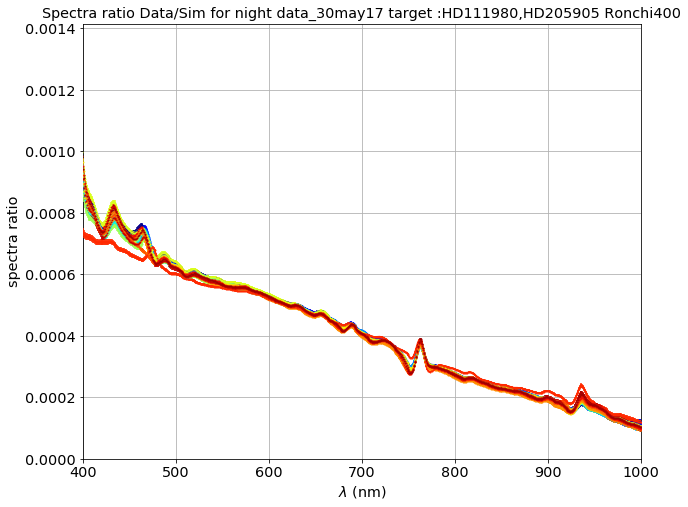

In [111]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [112]:
#PlotSpectraRatio(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,thetitle,Flag_corr_wl=True)

In [113]:
#PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,thetitle,Flag_corr_wl=True)

the_Y_min,the_Y_max = 3.45976459146e-05 0.0028289375908


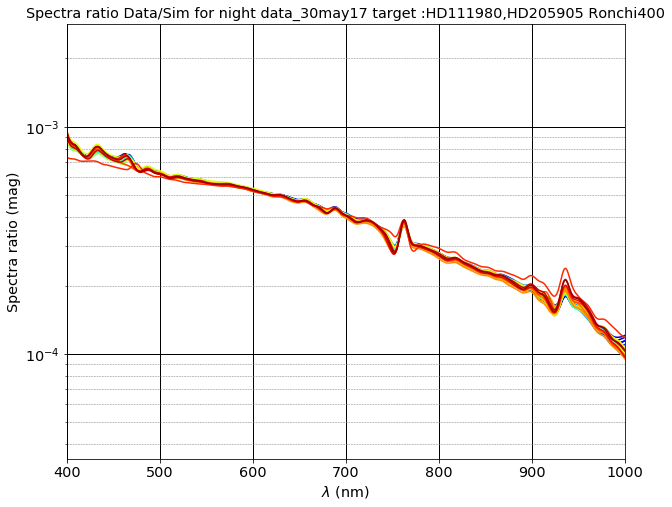

In [114]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [115]:
the_ratio_file="ratiosmooth_Ron400.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

../../../SpectractorAnaAtm/common_tools/libspecana.py:758: RuntimeWarning: divide by zero encountered in divide
  ratio=fl0/fl2
../../../SpectractorAnaAtm/common_tools/libspecana.py:758: RuntimeWarning: invalid value encountered in divide
  ratio=fl0/fl2


In [116]:
#arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,"ratio_Ron400.fits",Flag_corr_wl=True)

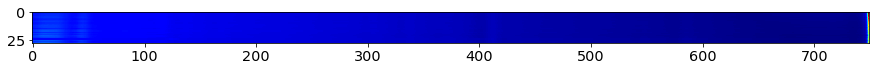

In [117]:
plt.imshow(arr[1:,:],cmap='jet')

## spectra ratio for Thor300

In [118]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

In [119]:
#PlotSpectraRatio(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,thetitle,Flag_corr_wl=True)

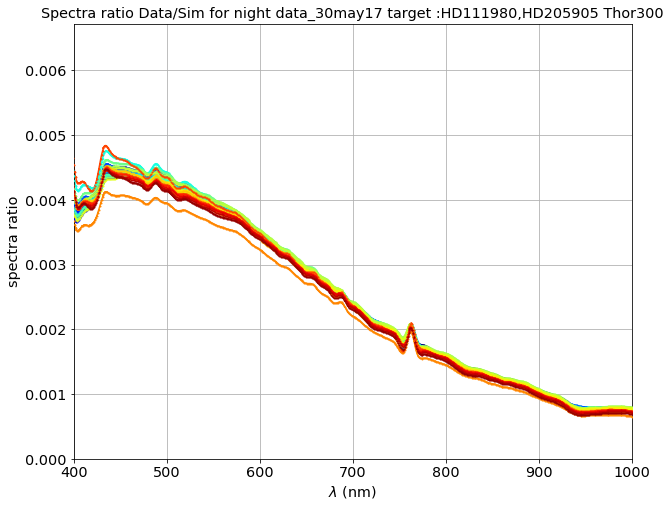

In [120]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [121]:
#PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_Thor300,SearchTagRe,thetitle,Flag_corr_wl=True)

the_Y_min,the_Y_max = 0.000224595003577 0.0134381897167


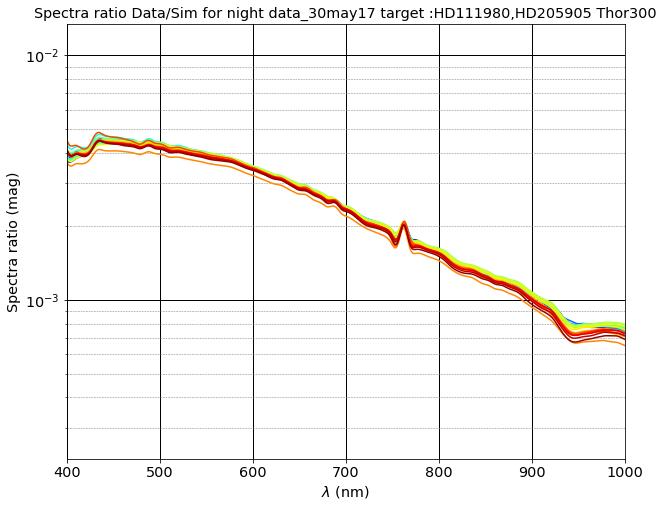

In [122]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [123]:
the_ratio_file="ratiosmooth_Thor300.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

In [124]:
#arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_Thor300,SearchTagRe,"ratio_Thor300.fits",Flag_corr_wl=True)

## spectra ratio for HoloPhP

In [125]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

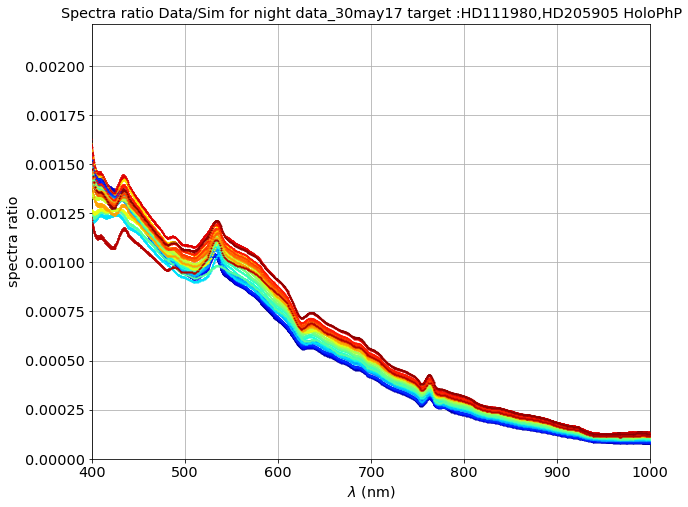

In [126]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [127]:
#PlotSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhP,SearchTagRe,thetitle,Flag_corr_wl=True)

In [128]:
#PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhP,SearchTagRe,thetitle,Flag_corr_wl=True)

the_Y_min,the_Y_max = 4.14538604239e-05 0.0044258533511


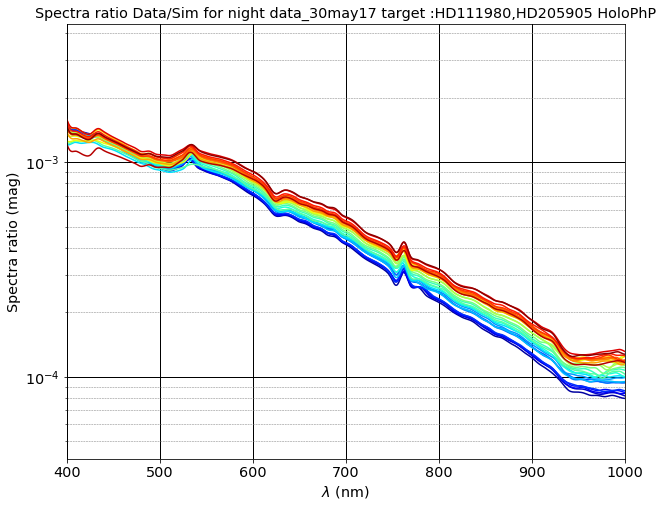

In [129]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [130]:
#arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhP,SearchTagRe,"ratio_HoloPhP.fits",Flag_corr_wl=True)

In [131]:
the_ratio_file="ratiosmooth_HoloPhP.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Spectrum ratio for HoloPhAg

In [132]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

In [133]:
#PlotSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhAg,SearchTagRe,thetitle,Flag_corr_wl=True,YMIN=0,YMAX=0.002)

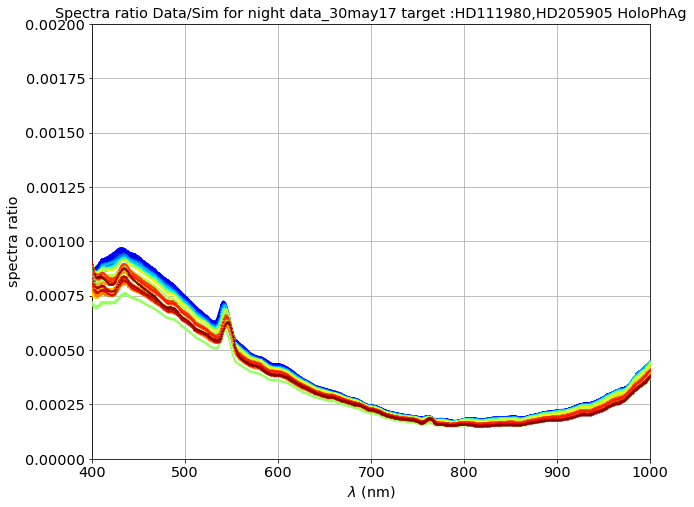

In [134]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0.002)

In [135]:
#PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhAg,SearchTagRe,thetitle,Flag_corr_wl=True,YMIN=1e-6,YMAX=1e-2)

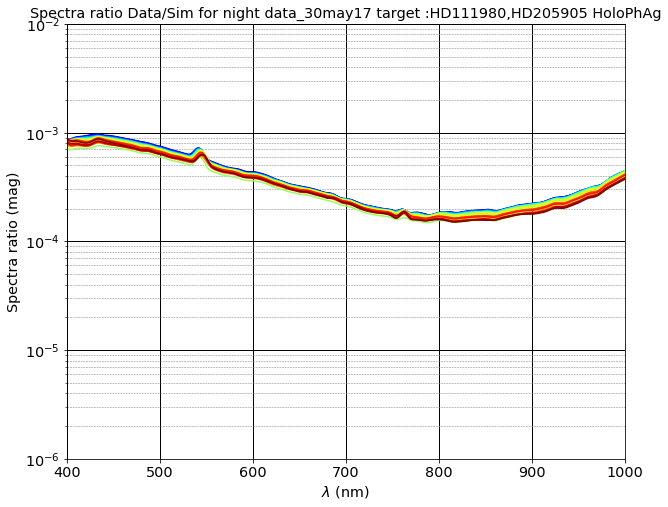

In [136]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=1e-6,YMAX=1e-2)

In [137]:
#arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhAg,SearchTagRe,"ratio_HoloPhAg.fits",Flag_corr_wl=True)

In [138]:
the_ratio_file="ratiosmooth_HoloPhAg.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)              

## Spectrum ratio for HoloAmAg

In [139]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

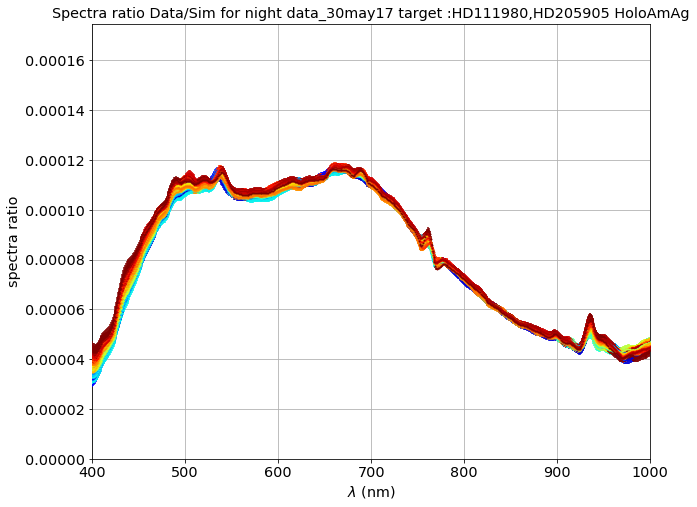

In [140]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim2,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [141]:
#PlotSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,thetitle,Flag_corr_wl=True)

In [142]:
#PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,thetitle,Flag_corr_wl=True)

the_Y_min,the_Y_max = 1.26244233539e-05 0.000326580883936


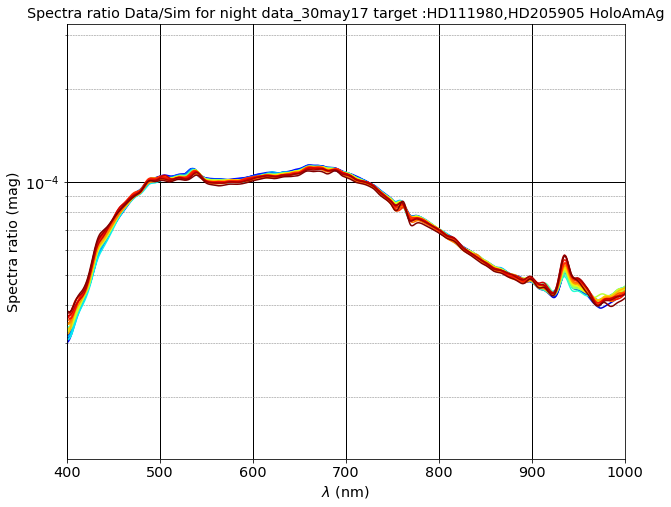

In [143]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [144]:
the_ratio_file="ratiosmooth_HoloAmAg.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloAmAg,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)    

In [145]:
#arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,"ratio_HoloAmAg.fits",Flag_corr_wl=True)

In [146]:
!ls *.fits

ratio_HoloAmAg.fits       ratio_Thor300.fits        ratiosmooth_Ron400.fits
ratio_HoloPhAg.fits       ratiosmooth_HoloAmAg.fits ratiosmooth_Thor300.fits
ratio_HoloPhP.fits        ratiosmooth_HoloPhAg.fits
ratio_Ron400.fits         ratiosmooth_HoloPhP.fits
